# PERSAMAAN PANAS 1 DIMENSI

In [2]:
import deepxde as dde
import numpy as np

# library untuk membuat animasi:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



In [3]:
# pengaturan
plt.rcParams['animation.ffmpeg_path'] = r'C:\FFmpeg\bin\ffmpeg.exe'
dde.config.set_default_float("float64")
dde.optimizers.config.set_LBFGS_options(maxiter=15000)

Set the default float type to float64


# PINN

In [4]:
# solusi analitik persamaan panas 1d
def heat_eq_exact_solution(x, t):
    return np.exp(-(np.pi**2 * a * t)) * np.sin(np.pi * x)

# fungsi untuk menghitung solusi analitik
def gen_exact_solution():
    # jumlah titik tiap dimensi:
    x_dim, t_dim = (1000, 1000)

    # batas dari x dan t:
    x_min, t_min = (0, 0.0)
    x_max, t_max = (L, maxtime)

    # titik titik yg akan dicari solusinya:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # peroleh solusi tiap titik:
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i], t[j])

    # Save:
    np.savez("heat_eq_data", x=x, t=t, usol=usol)

# fungsi untuk membaca data analitik
def gen_testdata():
    # Load data:
    data = np.load("heat_eq_data.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    # ratakan data:
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

In [5]:
# Problem parameters:
a = 0.4  # Thermal diffusivity
L = 1  # panjang interval
maxtime = 1

In [6]:
# peroleh solusi analitik
gen_exact_solution()

In [7]:
def pde(x, y):
    # persamaan diferensial parsial: persamaan panas 1d
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx

In [8]:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, maxtime)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [9]:
# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(np.pi * x[:, 0:1]),
    lambda _, on_initial: on_initial,
)


In [10]:
# definisi PDP dan konfigurasi neural network
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([2] + [32] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [11]:
# Bangun dan latih model dengan 2 metode optimasi
model.compile("adam", lr=1e-3, loss_weights=[1, 1, 1])
model.train(iterations=10000)
model.compile("L-BFGS", loss_weights=[1, 1, 1])
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.074149 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.636483 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.71e-02, 2.11e-01, 1.11e+00]    [6.15e-02, 2.11e-01, 1.11e+00]    []  
1000      [8.38e-04, 4.48e-04, 2.44e-04]    [4.43e-04, 4.48e-04, 2.44e-04]    []  
2000      [7.50e-05, 1.96e-05, 1.89e-05]    [3.92e-05, 1.96e-05, 1.89e-05]    []  
3000      [1.24e-04, 4.76e-05, 1.68e-04]    [1.00e-04, 4.76e-05, 1.68e-04]    []  
4000      [1.86e-05, 4.78e-06, 2.25e-06]    [1.09e-05, 4.78e-06, 2.25e-06]    []  
5000      [9.97e-06, 1.48e-06, 9.22e-07]    [5.67e-06, 1.48e-06, 9.22e-07]    []  
6000      [7.38e-06, 9.58e-07, 3.40e-07]    [4.35e-06, 9.58e-07, 3.40e-07]    []  
7000      [4.50e-05, 1.28e-05, 3.66e-05]    [3.76e-05, 1.28e-05, 3.66e-05]    []  
8000      [1.31e-05, 2.83e-06, 6.27e-06]    [1.02e-05, 2.83e-06, 6.27e-06]    []  
9000      [5.48e-06, 3.48e-07, 8.61e-08]    [3.28e-06, 3.48e-07, 8.61e-08]    []  
10000     [5.21e-06, 2.49e-07, 7.4

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


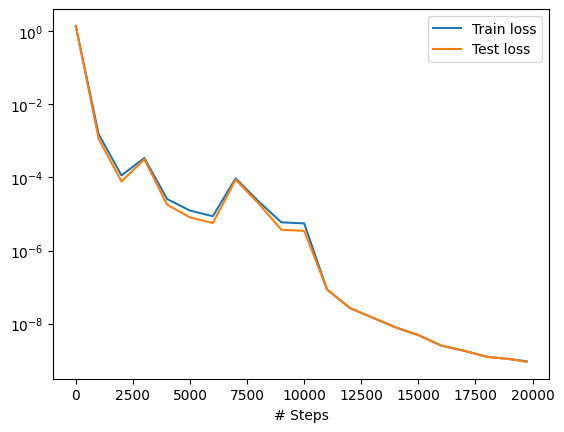

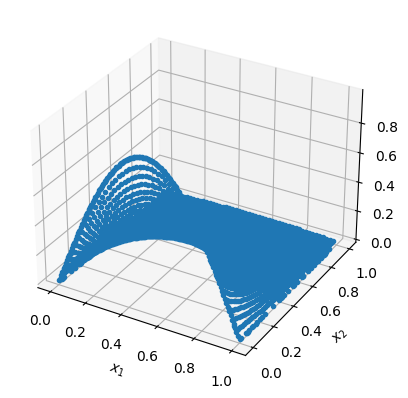

Mean squared error: 4.5684487252696106e-11
peak PINN:  [0.99999477]


In [12]:
# Plot/print hasil
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, y_true = gen_testdata()
y_PINN = model.predict(X)
print("Mean squared error:", dde.metrics.mean_squared_error(y_true, y_PINN))
print("peak PINN: ", max(y_PINN))
np.savetxt("test.dat", np.hstack((X, y_true, y_PINN)))

# Numeric FTCS

In [13]:
# library untuk menghitung waktu running FTCS
import time
start = time.time()

# deklarasi ukuran diferensial
nt = np.isclose(X[:, 0], 0).sum()*10

dt = maxtime/nt
dx = 0.01

In [14]:
dt

0.0001

In [15]:
# inisialisasi domain
xs = np.arange(0, L, dx)
ts = np.arange(0, maxtime, dt)
u = np.sin(np.pi*xs)     #initial condition

u[0] = 0   #boundary condition
u[-1] = 0

y_num = np.empty(3)

for n in ts:  #iterasi melalui waktu
    un = u.copy()
    u[1:-1] = un[1:-1] + a * dt / dx**2 * (un[2:] - 2 * un[1:-1] + un[0:-2])
    u[0] = 0
    u[-1] = 0
#     for i in range(1, len(u)-1):
#         u[i] = un[i] + a * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])
    temp = np.hstack((xs.reshape(-1,1), np.full(len(xs), n).reshape(-1,1), u.reshape(-1,1)))
    y_num = np.vstack((y_num, temp))

y_num = np.delete(y_num, 0, 0)
end = time.time()

In [16]:
print('total waktu kalkulasi FTCS', end-start)
print('mean squared error FTCS: ', dde.metrics.mean_squared_error((heat_eq_exact_solution(y_num[:, 0], y_num[:, 1])), y_num[:, 2]))
print('peak FTCS: ', max(y_num[:, 2]))

total waktu kalkulasi FTCS 14.821287393569946
mean squared error FTCS:  2.827263170064616e-05
peak FTCS:  0.9996052482925852


# Animation

In [17]:
result = np.hstack((X, y_true, y_PINN))
time = np.unique(result[:, 1])
time2 = np.unique(y_num[:, 1])

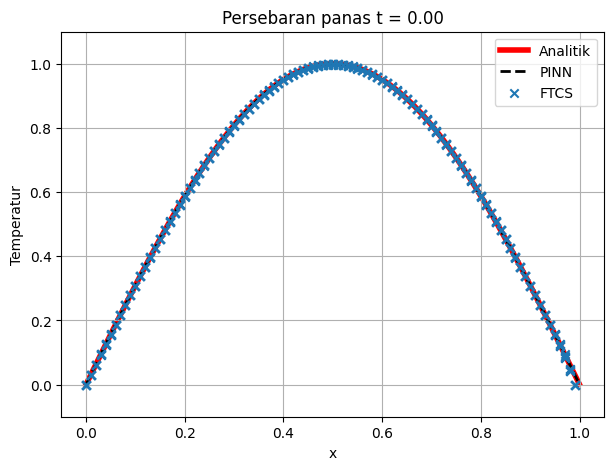

In [18]:
fig, ax = plt.subplots(figsize=(7,5))

def update(frame):
    ax.clear()
    ax.set_title(" ")
    ax.set_ylim([-.1, 1.1])
    ax.set_ylabel("Temperatur")
    ax.set_xlabel("x")
    ax.grid()
    a = np.where(result[:, 1] == time[frame])[0][0]
    b = np.where(result[:, 1] == time[frame])[0][-1]
    c = np.where(np.isclose(y_num[:, 1], time[frame], atol=5e-4))[0][0]
    d = np.where(np.isclose(y_num[:, 1], time[frame], atol=5e-4))[0][-1]
    ax.plot(result[a:b, 0], result[a:b, 2], 'r-', linewidth=4, label = 'Analitik', zorder = 0)
    ax.plot(result[a:b, 0], result[a:b, 3], 'k--', linewidth=2, label = 'PINN', zorder = 5)
    ax.scatter(y_num[c:d, 0], y_num[c:d, 2], marker='x', label = 'FTCS', zorder = 10)
    ax.set_title("Persebaran panas t = {:.2f}".format(result[a, 1]))
    ax.legend()

ani = FuncAnimation(fig, update, frames=int(len(time)))

In [19]:
# HTML(ani.to_jshtml(60))

In [20]:
# Save animasi sebagai gif
# ani.save("heat eq 1d nozoom.gif", dpi=200, fps=30)

# Plot

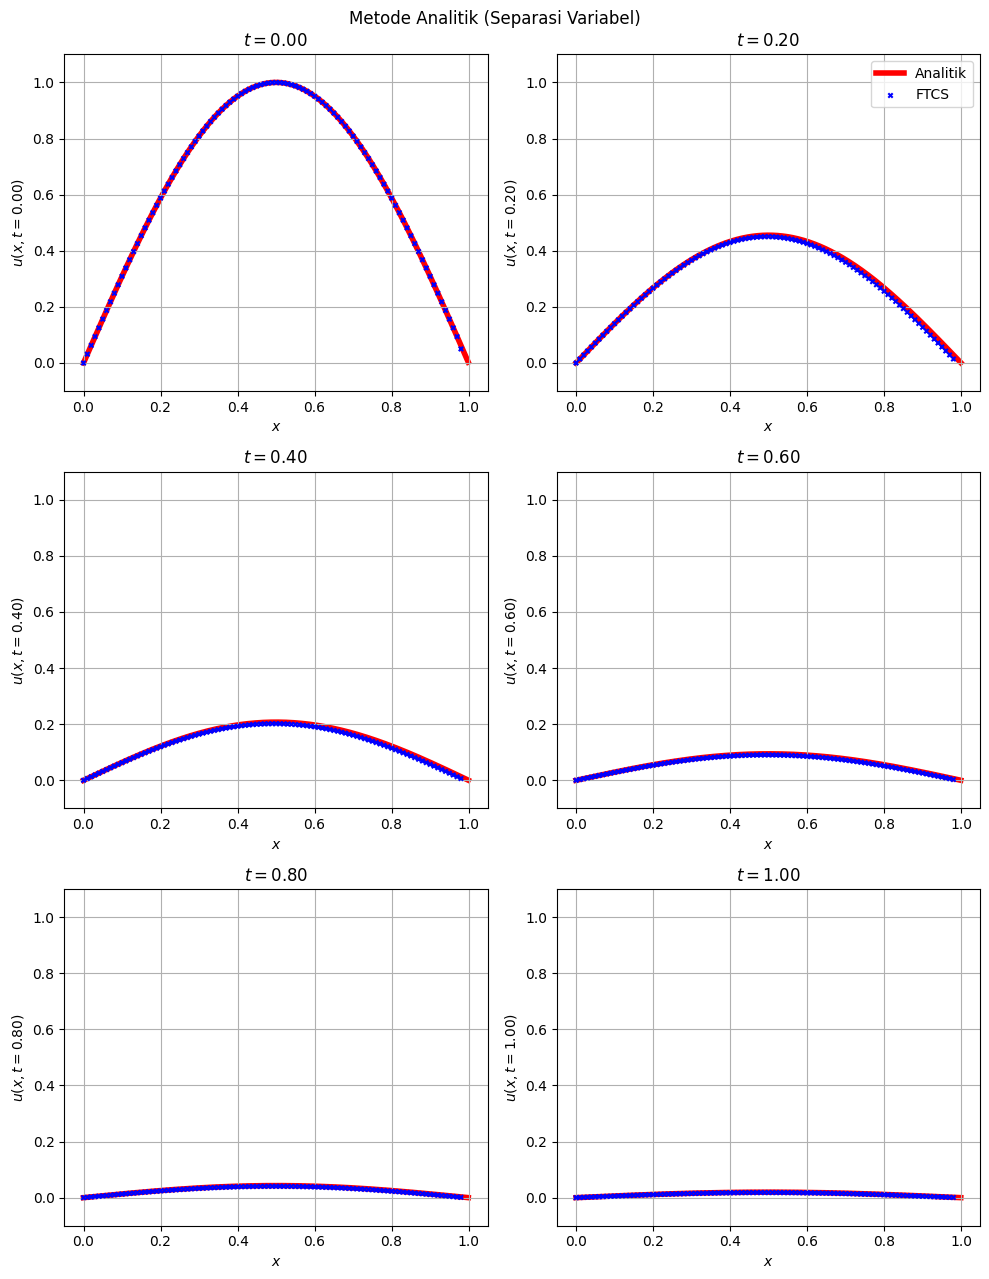

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(10,13))
figTime = 0
fig.suptitle("Metode Analitik (Separasi Variabel)")
for ax in axs.flat:
    ax.grid()
    ax.set(xlabel='$x$', ylabel='$u(x, t = {:.2f})$'.format(time[figTime]))
    ax.set_ylim([-.1, 1.1])
#     ax.set_ylim([.975, 1.])
#     ax.set_xlim([0.4, .6])
    markersize = [10 for i in range(len(y_num[np.where(np.isclose(y_num[:, 1],time[figTime]))[0][0]:np.where(np.isclose(y_num[:, 1],time[figTime]))[0][-1], 0]))]
    ax.plot(result[np.where(result[:, 1] == time[figTime])[0][0]:np.where(result[:, 1] == time[figTime])[0][-1], 0], result[np.where(result[:, 1] == time[figTime])[0][0]:np.where(result[:, 1] == time[figTime])[0][-1], 2], 'r-', linewidth=4, label = 'Analitik', zorder = 0)
#     ax.plot(result[np.where(result[:, 1] == time[figTime])[0][0]:np.where(result[:, 1] == time[figTime])[0][-1], 0], result[np.where(result[:, 1] == time[figTime])[0][0]:np.where(result[:, 1] == time[figTime])[0][-1], 3], 'k--', linewidth=2, label = 'PINN', zorder = 5)
    ax.scatter(y_num[np.where(np.isclose(y_num[:, 1],time[figTime]))[0][0]:np.where(np.isclose(y_num[:, 1],time[figTime]))[0][-1], 0], y_num[np.where(np.isclose(y_num[:, 1],time[figTime]))[0][0]:np.where(np.isclose(y_num[:, 1],time[figTime]))[0][-1], 2], markersize, marker='x', c='b', label = 'FTCS', zorder = 10)
    ax.set_title("$t = {:.2f}$".format(time[figTime]))
    figTime += 199

axs[0,1].legend()

plt.tight_layout()
# plt.savefig("analytic.png", dpi=300)

In [22]:
# mengukur MSE tiap metode
from sklearn.metrics import mean_squared_error as MSE
print('\033[1m' + "Method         Peak                   MSE" + '\033[0m' +
      "\nAnalytic      ", heat_eq_exact_solution(result[:, 0], result[:, 1]).max(),
      "\nFTCS          ", y_num[:,2].max(),"   ", MSE(y_num[:,2], heat_eq_exact_solution(y_num[:,0], y_num[:,1])),
      "\nPINN          ", result[:, 3].max(),"   ", MSE(result[:, 3], heat_eq_exact_solution(result[:, 0], result[:, 1]))
     )

Method         Peak                   MSE
Analytic       0.9999987638285974 
FTCS           0.9996052482925852     2.827263170064616e-05 
PINN           0.9999947703961294     4.5684487252696106e-11


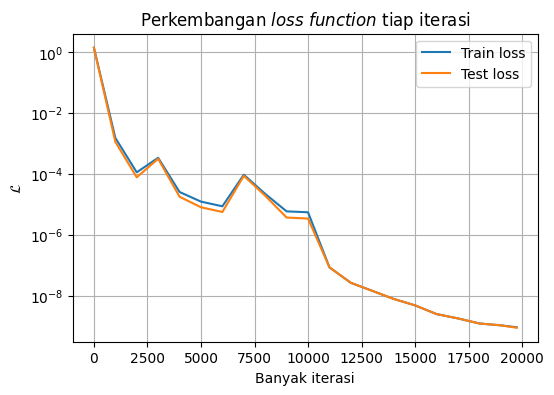

In [23]:
# loss history
loss_train = np.sum(losshistory.loss_train, axis=1)
loss_test = np.sum(losshistory.loss_test, axis=1)

plt.figure(figsize=(6,4))
plt.grid()
plt.title("Perkembangan $loss$ $function$ tiap iterasi")
plt.semilogy(losshistory.steps, loss_train, label="Train loss")
plt.semilogy(losshistory.steps, loss_test, label="Test loss")
for i in range(len(losshistory.metrics_test[0])):
    plt.semilogy(
        loss_history.steps,
        np.array(loss_history.metrics_test)[:, i],
        label="Test metric",
    )
plt.xlabel("Banyak iterasi")
plt.ylabel("$\mathcal{L}$")
plt.legend()
plt.savefig('loss.png', dpi=300)